## ovr-svm

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gc
import os
import re
import pickle
import sklearn
import sys
import string


from datetime import datetime
from sklearn.externals import joblib
from sklearn.metrics import f1_score, precision_score, recall_score,average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.decomposition import LatentDirichletAllocation

from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.delicious_t140
%aimport src.helpers.labels
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics,src.utils.plotting

In [4]:
from src.features.delicious_t140 import clean_text_delicious
from src.data.delicious_t140 import get_sample_from_cache
from src.helpers.labels import truncate_labels
from src.utils.metrics import ranking
from src.utils.dataframes import sample_rows
from src.utils.plotting import plot_micro_f1_at_k

In [5]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/delicious-ovr-linear-svc-calibrated")
DATA_ROOT = "/media/felipe/SAMSUNG/delicious/delicioust140"
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/delicious-t140/")
OUTPUT_FILE = 'output-linear-svc-'+ datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.txt'

MAX_NB_WORDS = 500
SEED= 42
MIN_TAG_DF=10
SAMPLE_FRAC=20

In [6]:
np.random.seed(SEED)

In [7]:
docs_df = get_sample_from_cache(INTERIM_DATA_ROOT,SAMPLE_FRAC)

In [8]:
docs_df.head(1)

,filename,filetype,hash,tags,url,num_users,num_tags,contents
0,26313806abe42032de4f612017738426.html,html,26313806abe42032de4f612017738426,"tutoriel,multimedia,english,screencasts,videos...",http://screencasts.ubuntu.com/,228,23,"Ubuntu Screencasts @import ""/misc/drupal.css""..."


In [9]:
len(docs_df)

28743

In [10]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))
labels = truncate_labels(labels,MIN_TAG_DF)

In [11]:
np.random.seed(SEED)

mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['contents'].values
indices = np.arange(len(data))
np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 3305 
total number of train documents: 24432
total number of validation documents: 4311


In [22]:
parameters = [
    { 
        "vect__max_features": [500],
        "vect__norm": ['l1','l2',None],
        "lda__n_components":[5,10,50,100],
        "svm__kernel":["rbf"]
    }
]

In [23]:
for g in ParameterGrid(parameters):
    print(g)
    vect=TfidfVectorizer().set_params(**dict([
        (re.sub('^vect__','',k),v) for (k,v) in g.items() if k.startswith('vect__') ]))
        
    vect.fit(X_train)
    
    X_train_vect = vect.transform(X_train)
    X_val_vect = vect.transform(X_val)
    
    number_of_components = g['lda__n_components']
    
    cache_path = INTERIM_DATA_ROOT+"/lda-NBCOMPS={}NBWORDS={}SEED={}.p".format(number_of_components,MAX_NB_WORDS,SEED)

    # cache the lda model because it's expensive to build
    if os.path.isfile(cache_path):
        print('cache hit')
        lda=joblib.load(open(cache_path,"rb"))
    else:
        print('calculating LDA model for {} components'.format(number_of_components))
        lda = LatentDirichletAllocation(n_components=number_of_components, learning_method='online')
        lda.fit(X_train_vect)
        joblib.dump(lda,open(cache_path,"wb"))

    # these are the topic distributions
    
    X_train_vect = lda.transform(X_train_vect)
    X_val_vect = lda.transform(X_val_vect)
    
    svm = SVC().set_params(**dict([(re.sub('^svm__','',k),v) for (k,v) in g.items() if k.startswith('svm__') ]))
    
    clf = OneVsRestClassifier(CalibratedClassifierCV(svm,cv=2),n_jobs=4)

    clf.fit(X_train_vect,Y_train)

    Y_pred_val = clf.predict_proba(X_val_vect)
                  
    ks = [1,2,3,4,5,6,7,8,9,10]
        
    # k is the number of neighbors so let's use at_k
    for at_k in ks:
        print("validation micro-F1 @{}: {}".format(at_k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=at_k,normalize=True))) 
        
    print('')    

{'lda__n_components': 5, 'vect__norm': 'l1', 'vect__max_features': 500, 'svm__kernel': 'rbf'}
cache hit
validation micro-F1 @1: 0.3658074298711145
validation micro-F1 @2: 0.34160415464512406
validation micro-F1 @3: 0.33498551657547476
validation micro-F1 @4: 0.3276112889147512
validation micro-F1 @5: 0.31212560197329786
validation micro-F1 @6: 0.29571061474599725
validation micro-F1 @7: 0.28909173375666175
validation micro-F1 @8: 0.28208512863938634
validation micro-F1 @9: 0.274488003379956
validation micro-F1 @10: 0.2686399325287656

{'lda__n_components': 5, 'vect__norm': 'l2', 'vect__max_features': 500, 'svm__kernel': 'rbf'}
cache hit
validation micro-F1 @1: 0.3988857938718663
validation micro-F1 @2: 0.3602130087485736
validation micro-F1 @3: 0.3431975403535742
validation micro-F1 @4: 0.3272868367445921
validation micro-F1 @5: 0.31588405344167514
validation micro-F1 @6: 0.30398006688086027
validation micro-F1 @7: 0.29098116947472746
validation micro-F1 @8: 0.2842217855277232
validati

In [ ]:
%%time

for g in ParameterGrid(parameters):
    print(g)
    pipeline.set_params(**g)
    
    pipeline.fit(X_train,Y_train)
    
    Y_pred_train = pipeline.predict_proba(X_train)    
    Y_pred_val = pipeline.predict_proba(X_val)
    
    ks = [1,2,3,4,5,6,7,8,9,10]
        
    # k is the number of neighbors so let's use at_k
    for k in ks:
        print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=k,normalize=True))) 

In [ ]:
pickle.dump(pipeline,open(MODELS_ROOT+'/model-sample-{}.p'.format(SAMPLE_FRAC),'wb'))

### e sem calibrar?

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

pipeline2 = Pipeline([
    ('vect', TfidfVectorizer()),
    # https://stackoverflow.com/a/39712590/436721
    ('clf', OneVsRestClassifier(LinearSVC(),n_jobs=-1)),
])

parameters = [
    {
        "vect__max_features": [MAX_NB_WORDS]
    }
]

In [ ]:
%%time

for g in ParameterGrid(parameters):
    print(g)
    pipeline2.set_params(**g)
    
    pipeline2.fit(X_train,Y_train)

In [ ]:
Y_pred_val = pipeline2.decision_function(X_val)

In [ ]:
np.set_printoptions(edgeitems=1000)
Y_pred_val[0]

In [ ]:
np.abs(Y_pred_val[0])

In [ ]:
Y_pred_val = pipeline2.decision_function(X_val)

ks = [1,2,3,4,5,6,7,8,9,10]

# k is the number of neighbors so let's use at_k
for k in ks:
    print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=k,normalize=True)))

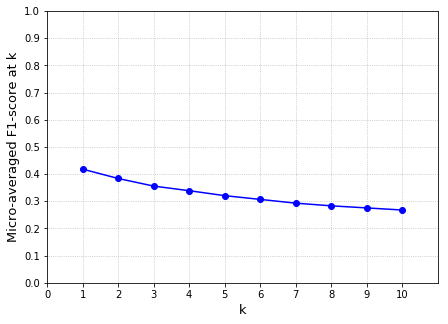

In [24]:
plt.clf()
img = plt.gcf()
ax = plt.gca()
validation_scores = [
0.41827187671986793,
0.3838800374882849,
0.35583524027459956,
0.3388883537231481,
0.3206731331073975,
0.30686653138705244,
0.2930595621924317,
0.2831968539213978,
0.27552335659362637,
0.2678051230537418
]
plot_micro_f1_at_k(validation_scores,ax=ax)
plt.gcf().set_size_inches(7,5)
plt.gca().legend_.remove()
plt.show()